# SWIFTGalaxy quick start guide for Colibre on cosma

First some notes on package versions:
 - Thanks to Josh Borrow for putting up with my pestering and fixing bugs at the last minute. Also to Rob McGibbon for work on SOAP support in `swiftsimio`.
 - Doing `pip install swiftgalaxy` should install `swiftgalaxy` with SOAP support and its dependencies with compatible versions. Version `2.0.0` or newer is needed for this example notebook.
 - The required version of `swiftsimio` (at least `10.0.0`) can be installed directly with `pip install swiftsimio`.
You can check your `swiftsimio` and `swiftgalaxy` versions with the next cell. If it produces import errors you probably have incompatible package versions for `swiftsimio`, `swiftgalaxy` and/or others.
 - This tutorial also uses `matplotlib` that's not a required dependency of the packages above (so `pip install matplotlib` if not already done).

In [1]:
import swiftgalaxy
import swiftsimio
from packaging.version import Version

assert Version(swiftsimio.__version__) >= Version("10.0.0")
assert Version(swiftgalaxy.__version__) >= Version("2.0.0")

We'll use this SOAP catalogue in this example:

In [2]:
import os

colibre_base_path = "/cosma8/data/dp004/colibre/Runs/"
simulation_dir = "L0025N0752/THERMAL_AGN_m5"
soap_catalogue_file = os.path.join(
    colibre_base_path,
    simulation_dir,
    "SOAP/halo_properties_0127.hdf5",
)

SOAP records which particles belong to each individual halo in a set of "membership" files, usually found alongside the halo catalogue in a subdirectory, in this case `membership_0127/membership_0127.X.hdf5` (where X is replaced by integers, each corresponding to one part of the "raw" snapshot). `swiftgalaxy` expects to find the information contained in these files directly in the (single, monolithic) simulation snapshot file. Such a snapshot file exists alongside the SOAP catalogue as `colibre_with_SOAP_membership_0127.hdf5`.

In [3]:
virtual_snapshot_file = os.path.join(
    colibre_base_path, simulation_dir, "SOAP/colibre_with_SOAP_membership_0127.hdf5"
)

We can load the entire SOAP catalogue using `swiftsimio` to browse for an interesting galaxy to look at. To avoid having too many particles let's pick something with an m200c of about 1e11 Msun. We'll just grab the first eligible galaxy in the list:

In [4]:
import numpy as np
import unyt as u  # package used by swiftsimio to provide physical units
from swiftsimio import SWIFTDataset, cosmo_quantity

sd = SWIFTDataset(soap_catalogue_file)
m200c = sd.spherical_overdensity_200_crit.total_mass
candidates = np.argwhere(
    np.logical_and(
        m200c
        > cosmo_quantity(
            1e11, u.Msun, comoving=True, scale_factor=sd.metadata.a, scale_exponent=0
        ),
        m200c
        < cosmo_quantity(
            2e11, u.Msun, comoving=True, scale_factor=sd.metadata.a, scale_exponent=0
        ),
    )
).squeeze()
chosen_halo_index = candidates[0]
print(chosen_halo_index)

21324


Now we can create a `SWIFTGalaxy` to experiment with. The `halo_index` selects one row from the halo catalogue. The `SWIFTGalaxy` object will contain all of the integrated properties of this object from the halo catalogue and also let us access its particles from the snapshot file.

In [5]:
from swiftgalaxy import SWIFTGalaxy, SOAP

sg = SWIFTGalaxy(
    virtual_snapshot_file,
    SOAP(
        soap_catalogue_file,
        soap_index=chosen_halo_index,
    ),
)

We can define a function that uses some of `swiftsimio`'s visualisation tools to make some quick images of this galaxy:

In [6]:
from swiftsimio import cosmo_array
from swiftsimio.visualisation.projection import project_gas, project_pixel_grid
from swiftsimio.visualisation import (
    generate_smoothing_lengths,
)  # if not found try `from swiftsimio.visualisation import generate_smoothing_lengths`
import matplotlib.pyplot as plt
import matplotlib.colors


def myvis(sg, disc_radius=15.0 * u.kpc, halo_radius=200.0 * u.kpc, fignum=1):
    # Before visualising the galaxy, we need to initialise some smoothing
    # lengths for the dark matter particles (this bit of code is taken
    # from the `swiftsimio` visualisation documentation).
    if not hasattr(sg.dark_matter, "smoothing_lengths"):
        sg.dark_matter.smoothing_lengths = generate_smoothing_lengths(
            (sg.dark_matter.coordinates + sg.centre) % sg.metadata.boxsize,
            sg.metadata.boxsize,
            kernel_gamma=1.8,
            neighbours=57,
            speedup_fac=2,
            dimension=3,
        )
    disc_region = cosmo_array(
        [-disc_radius, disc_radius, -disc_radius, disc_radius],
        comoving=False,
        scale_factor=sg.metadata.a,
        scale_exponent=1,
    )
    halo_region = cosmo_array(
        [-halo_radius, halo_radius, -halo_radius, halo_radius],
        comoving=False,
        scale_factor=sg.metadata.a,
        scale_exponent=1,
    )
    gas_map = project_gas(
        sg,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,  # always recommended when using swiftgalaxy
        region=disc_region,
    )
    dm_map = project_pixel_grid(
        data=sg.dark_matter,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,  # always recommended when using swiftgalaxy
        region=halo_region,
    )
    star_map = project_pixel_grid(
        data=sg.stars,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,  # always recommended when using swiftgalaxy
        region=disc_region,
    )
    fig = plt.figure(fignum, figsize=(10, 3))
    sp1, sp2, sp3 = [fig.add_subplot(1, 3, i) for i in range(1, 4)]
    sp1.imshow(
        matplotlib.colors.LogNorm()(gas_map.to_value(u.solMass / u.kpc**2).T),
        cmap="viridis",
        extent=disc_region,
        origin="lower",
    )
    sp1.set_xlabel(f"x' [{disc_radius.units}]")
    sp1.set_ylabel(f"y' [{disc_radius.units}]")
    sp1.text(
        0.9, 0.9, "gas", color="white", ha="right", va="top", transform=sp1.transAxes
    )
    sp2.imshow(
        matplotlib.colors.LogNorm()(dm_map.to_value(u.solMass / u.kpc**2).T),
        cmap="inferno",
        extent=halo_region,
        origin="lower",
    )
    sp2.plot(
        [-disc_radius, -disc_radius, disc_radius, disc_radius, -disc_radius],
        [-disc_radius, disc_radius, disc_radius, -disc_radius, -disc_radius],
        "-k",
    )
    sp2.set_xlabel(f"x' [{halo_radius.units}]")
    sp2.set_ylabel(f"y' [{halo_radius.units}]")
    sp2.text(
        0.9, 0.9, "DM", ha="right", va="top", color="white", transform=sp2.transAxes
    )
    sp3.imshow(
        matplotlib.colors.LogNorm()(star_map.to_value(u.solMass / u.kpc**2).T),
        cmap="magma",
        extent=disc_region,
        origin="lower",
    )
    sp3.set_xlabel(f"x' [{disc_radius.units}]")
    sp3.set_ylabel(f"y' [{disc_radius.units}]")
    sp3.text(0.9, 0.9, "stars", ha="right", va="top", transform=sp3.transAxes)
    sp2.set_title(f"soap_index={sg.halo_catalogue.soap_index}")
    fig.subplots_adjust(wspace=0.4)
    return fig

Let's have a first look at our galaxy:

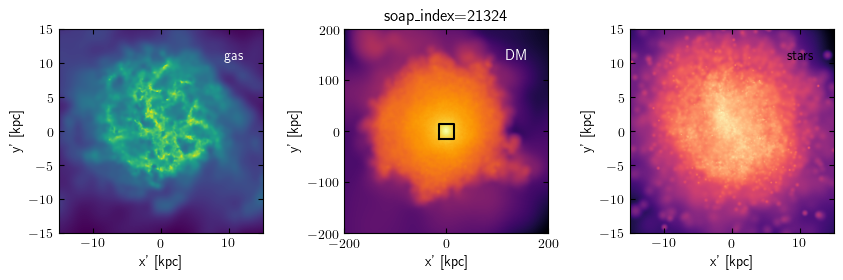

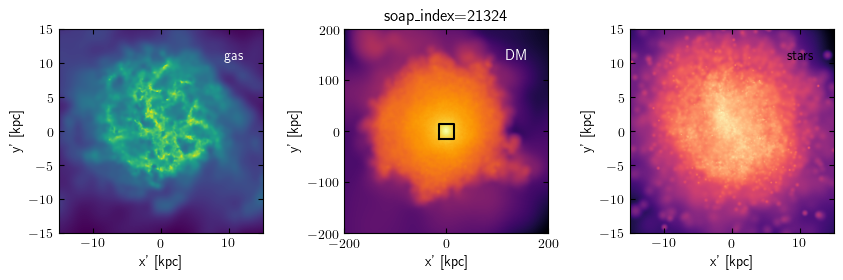

In [7]:
myvis(sg)

## Quick overview of `swiftgalaxy` features

### `SWIFTDataset` features

`SWIFTGalaxy` is built upon `swiftsimio` and takes advantage of all the features of the `SWIFTDataset` class, notably "lazy loading" of particle data. A `SWIFTGalaxy` inherits from the `SWIFTDataset` class, and should therefore in principle be accepted by functions expecting a `SWIFTDataset` (in practice there still some work to do on this front, e.g. some adjustments needed for some functions from the `swiftsimio.visualisation` module).

### SOAP integrated properties

A `swiftsimio` interface to the SOAP halo catalogue is exposed through the `halo_catalogue` attribute of our `SWIFTGalaxy`, and only the properties of the particular galaxy of interest are loaded. This makes accessing integrated properties particularly convenient, for instance we can grab M200crit:

In [8]:
sg.halo_catalogue.spherical_overdensity_200_crit.total_mass.to(u.Msun)

cosmo_array([1.728125e+11], dtype=float32, units='1.98841586e+30*kg', comoving='False', cosmo_factor='1 at a=0.9999999999999997', valid_transform='True')

Notice that this result has one more dimension than you might have been expecting (so the "scalar" mass is here an array with dimension `(1,)`, a 3-element array of coordinates would be a `(1,3)` array, etc.). This is for consistency with reading in a "full" SOAP catalogue (like the `sd` created a few cells above). You may wish to use `.squeeze()` on the result to remove any dimensions of size `1`.

### Automatic recentering

When the `SWIFTGalaxy` is created, the coordinates are automatically centred on the position and velocity (according to the halo finder) of the galaxy of interest. The SOAP catalogue actually contains many centres and velocities defined in different ways for each halo; which one to use is configurable. The automatic recentering can also be disabled entirely, or the centre of another `SWIFTGalaxy` can be used (can be useful e.g. for putting a satellite in the coordinate frame of its central).

### Rotation & other coordinate transformations

The particles in a `SWIFTGalaxy` always occupy a common coordinate frame, such that e.g. all particles rotate together. Rotations, translations (in position) and boosts (translations in velocity) are all supported. As an example, we can rotate our galaxy. To specify a rotation, the [`scipy.spatial.transform.Rotation`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html) class is used. This has options to accept rotation matrices, Euler angles, and more. The SOAP catalogue helpfully has pre-computed angular momentum vectors for particles of different types selected in different apertures. Let's use one of these to define a rotation matrix and rotate the stars to a face-on view.

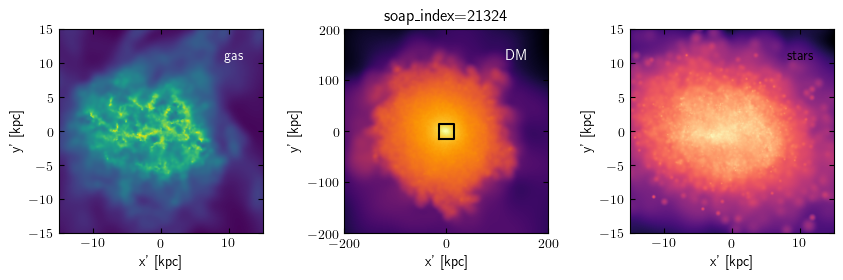

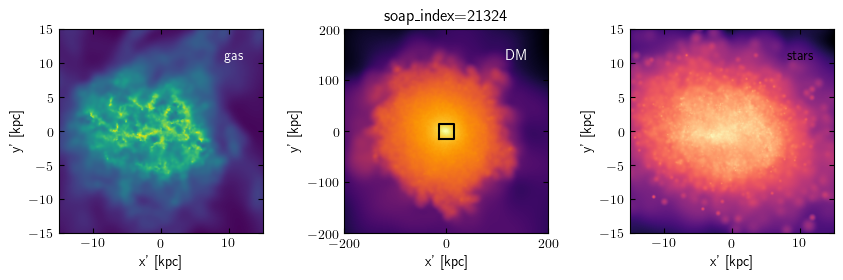

In [9]:
from scipy.spatial.transform import Rotation

Lstars = sg.halo_catalogue.exclusive_sphere_10kpc.angular_momentum_stars.squeeze()
zhat = (Lstars / np.sqrt(np.sum(Lstars**2))).to_value(
    u.dimensionless
)  # we'll align L with the z-axis
arb = np.ones(3) / np.sqrt(
    3
)  # we have one degree of freedom, we'll fix it by projecting onto an arbitrarily chosen vector
xvec = arb - arb.dot(zhat) * zhat
xhat = xvec / np.sum(xvec**2)
yhat = np.cross(zhat, xhat)  # orthogonal, right-handed and normalized
rotmat = np.vstack((xhat, yhat, zhat))
sg.rotate(Rotation.from_matrix(rotmat))
myvis(sg)

### Additional coordinates

When working with a galaxy it is often convenient to work in spherical or cylindircal coordinates. These are built into a `SWIFTGalaxy` and are evaluated lazily as and when needed. Their consistency when the coordinate frame is transformed is also ensured. As an illustrative example, we can plot the azimuthal velocity against the radial velocity - the parameters in which the Gaia-Enceladus (or "sausage") structure in the Milky Way was identified. This quick look won't reveal anything quite so profound but illustrates how easy it is to use non-cartesian coordinates.

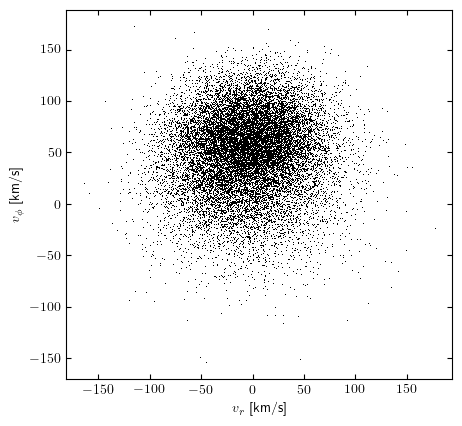

In [10]:
plt.plot(
    sg.stars.spherical_velocities.r.to_value(u.km / u.s),
    sg.stars.spherical_velocities.phi.to_value(u.km / u.s),
    ",k",
    rasterized=True,
)
plt.xlabel(r"$v_r$ [km/s]")
plt.ylabel(r"$v_\phi$ [km/s]")
plt.gca().set_aspect("equal")

### Particle masking

`SWIFTGalaxy` enables selecting subsets of particles in intuitive, syntactically simply ways (beyond what's supported by `swiftsimio`, actually). As a crude example, we can chop a hole out of the centre of the stellar and gas discs. Masking on any other property (gas of a given temperature, stars of a given age, etc.) is also possible, of course.

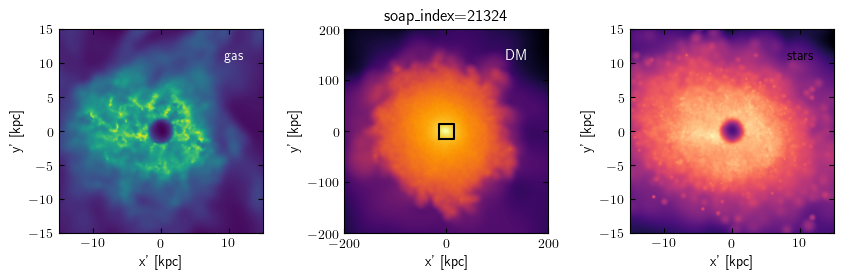

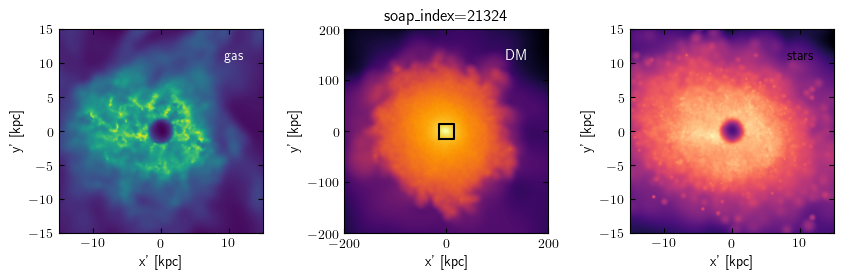

In [11]:
from swiftgalaxy import MaskCollection

sg.mask_particles(
    MaskCollection(
        gas=sg.gas.cylindrical_coordinates.R
        > cosmo_quantity(
            2, u.kpc, comoving=False, scale_factor=sg.metadata.a, scale_exponent=1
        ),
        stars=sg.stars.cylindrical_coordinates.R
        > cosmo_quantity(
            2, u.kpc, comoving=False, scale_factor=sg.metadata.a, scale_exponent=1
        ),
    )
)
myvis(sg)

The mask applies to all particle properties, e.g. if we next loaded the gas temperatures they would be masked to match. It's also possible to obtain masked particle datasets with `sg.gas[...]` (careful, unlike using `sg.mask_particles` these are copies, so memory consumption can increase quickly), amongst other options.

### Documentation

Detailed documentation for `swiftgalaxy` including descriptions of more options and more detailed explanations of features is [hosted on readthedocs](https://swiftgalaxy.readthedocs.io/en/latest/halo_finders/index.html). Any feedback on the code or documentation is very welcome by email (kyle.a.oman@durham.ac.uk), on Slack, or through an issue on the SWIFTGalaxy [github repository](https://github.com/SWIFTSIM/swiftgalaxy).

## Efficient iteration over galaxies

The `SWIFTGalaxy` demonstrated above offers a nice interface, but if looking at many galaxies using it adds substantial overhead (mostly duplicated I/O if any of the galaxies are spatially close together). The new `SWIFTGalaxies` class enables efficient iteration over `SWIFTGalaxy` objects.

Up above we gathered a list of candidate targets. Instead of looking only at the first one, let's iterate over the first 5 for this demo.

We can use the `SWIFTGalaxies` (not `SWIFTGalaxy`) class to help us iterate over these. This class offers most of the same options as the `SWIFTGalaxy` class, but expects a `SOAP` object with a `list` of targets passed to `soap_index` instead of a single integer. The `SWIFTGalaxies` class will figure out an efficient iteration strategy to minimize I/O.

Unfortunately the class cannot (yet?) guess what data you will want to use in the future, so to work efficiently it needs to know what fields it will need to make available (so that they can be read in once in advance for all galaxies in a common region). These are specified with the `preload` argument.

**Very important**: the iteration does not necessarily happen in the order that the `soap_index` list is given! The most efficient order is determined by `SWIFTGalaxies`. To obtain results in a list matching the input order, use the `map` method (see further below).

Iterating over galaxies [21324 23609 24135 45348 76280]
SWIFTGalaxy at /cosma8/data/dp004/colibre/Runs/L0025N0752/THERMAL_AGN_m5/SOAP/colibre_with_SOAP_membership_0127.hdf5.
SWIFTGalaxy at /cosma8/data/dp004/colibre/Runs/L0025N0752/THERMAL_AGN_m5/SOAP/colibre_with_SOAP_membership_0127.hdf5.
SWIFTGalaxy at /cosma8/data/dp004/colibre/Runs/L0025N0752/THERMAL_AGN_m5/SOAP/colibre_with_SOAP_membership_0127.hdf5.
SWIFTGalaxy at /cosma8/data/dp004/colibre/Runs/L0025N0752/THERMAL_AGN_m5/SOAP/colibre_with_SOAP_membership_0127.hdf5.
SWIFTGalaxy at /cosma8/data/dp004/colibre/Runs/L0025N0752/THERMAL_AGN_m5/SOAP/colibre_with_SOAP_membership_0127.hdf5.


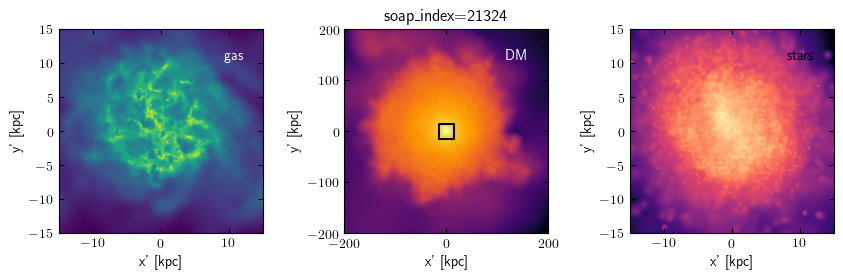

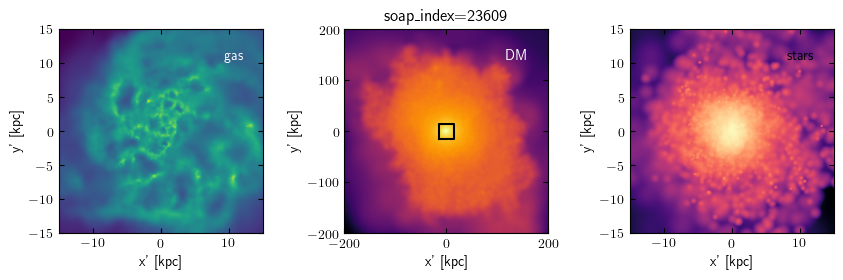

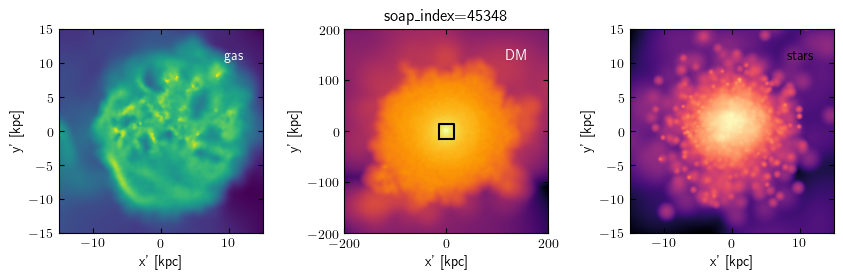

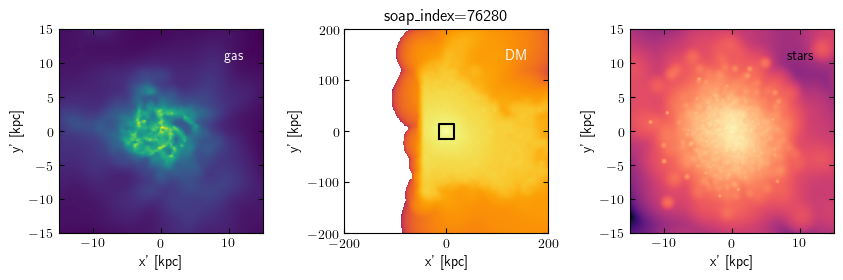

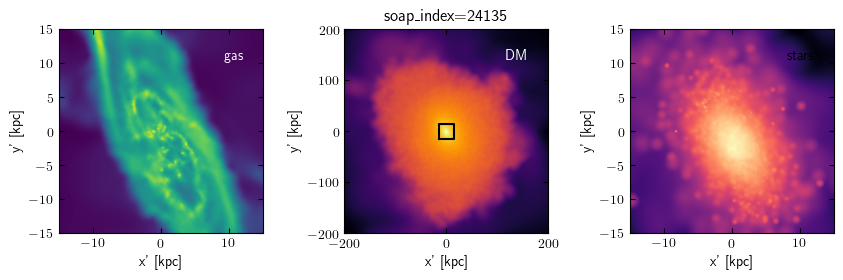

In [12]:
from swiftgalaxy.iterator import SWIFTGalaxies

soap_indices = candidates[:5]  # grab 5 objects from our list of targets

print(f"Iterating over galaxies {soap_indices}")

figcounter = 2
for sg in SWIFTGalaxies(
    virtual_snapshot_file,
    SOAP(
        soap_catalogue_file,
        soap_index=soap_indices,
    ),
    preload={
        "gas.coordinates",
        "gas.masses",
        "gas.smoothing_lengths",
        "dark_matter.coordinates",
        "dark_matter.masses",
        # dark matter has no smoothing lengths in snapshots
        "stars.coordinates",
        "stars.masses",
        "stars.smoothing_lengths",
    },
):
    print(sg)
    myvis(sg, fignum=figcounter)
    figcounter += 1

In this case the figures have (probably) appeared in the same order as the list of input targets, but we can consider this luck.

We can instead guarantee getting ordered results using the `map` method:

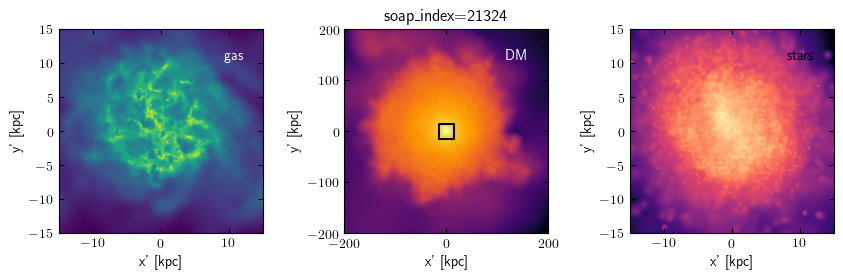

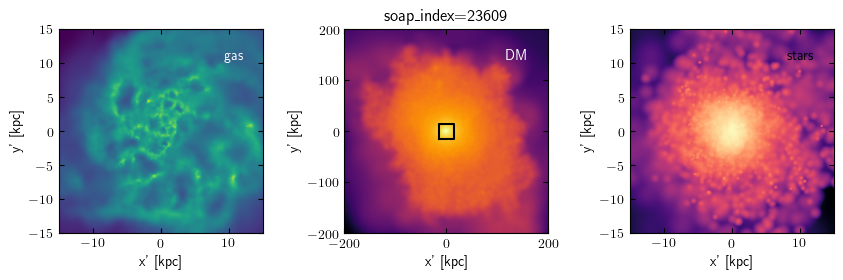

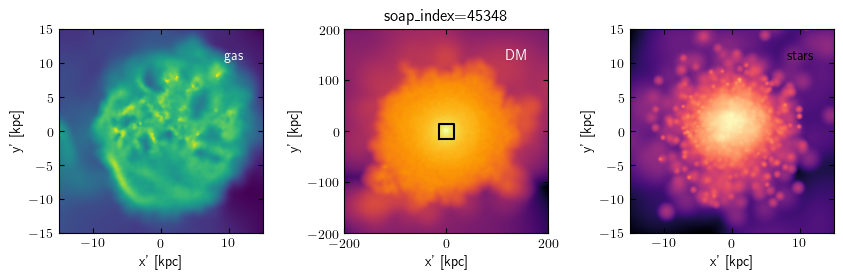

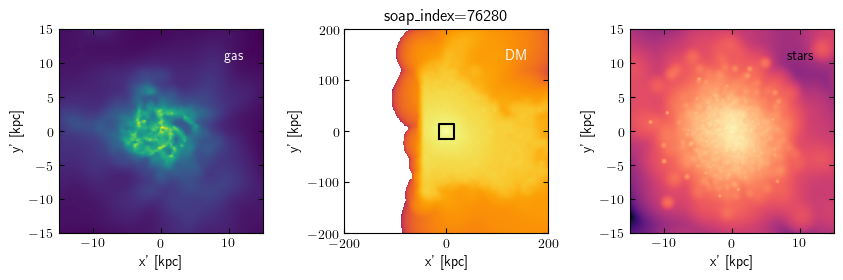

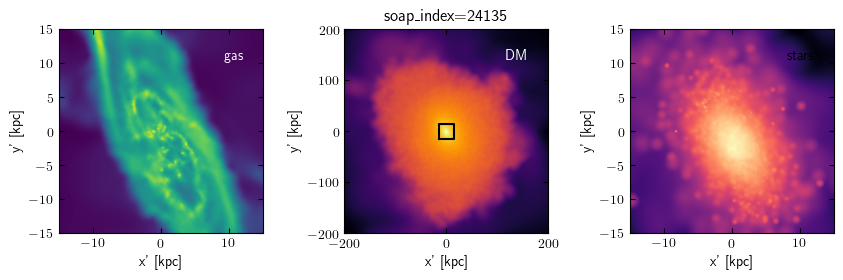

In [13]:
# we've used figs 1-6 above, continue from there:
output_fignums = [
    {"fignum": 7},
    {"fignum": 8},
    {"fignum": 9},
    {"fignum": 10},
    {"fignum": 11},
]
sgs = SWIFTGalaxies(
    virtual_snapshot_file,
    SOAP(
        soap_catalogue_file,
        soap_index=soap_indices,
    ),
    preload={
        "gas.coordinates",
        "gas.masses",
        "gas.smoothing_lengths",
        "dark_matter.coordinates",
        "dark_matter.masses",
        "stars.coordinates",
        "stars.masses",
        "stars.smoothing_lengths",
    },
)
# Use map to apply `myvis` to each `sg` in `sgs` and give us the results
# in order.
output_figures = sgs.map(myvis, kwargs=output_fignums)

The figures *could* still appear out of order in this notebook because, just to keep things "interesting", they appear in the order that they are created (the optimal order of iteration determined by `SWIFTGalaxies`), but the results *are* ordered correctly in `output_figures`.

By the way, in this particular example we've gained nothing by using `SWIFTGalaxies` to iterate over the galaxies because it turns out that the 5 galaxies chosen all live in different top-level cells in the simulation, precluding optimizing by only loading a top-level cell occupied by more than one galaxy once. At least `SWIFTGalaxies` has checked that this is the case for us...

Also, if running the examples seems a bit slow, it's because most of the time is spent calculating smoothing lengths, everything else happening actually runs pretty quickly on `cosma8`!

A final remark on the `SWIFTGalaxies` class: it seems obvious that one might want to split up the work of iterating over a large number of galaxies to multiple processors. Support for easy parallelization in both multiprocessing- and MPI-style modes will be coming in a future release!

## New feature: tab completion

Tab completion is supported (new in `swiftgalaxy` `v2.0.0`), so you can try interactions like `sg.<tab>`, `sg.gas.<tab>`, `sg.gas.element_mass_fractions.<tab>`, `sg.halo_catalogue.<tab>`, `sg.halo_catalogue.spherical_overdensity_200_crit.<tab>` in an interactive session to see all available fields and operations. This should work in IPython, Jupyter and newer Python interpreters. (In some interpreters you may need to press `<tab>` twice.) Because the listing is determined dynamically based on the metadata in the input `hdf5` file, so your IDE most likely cannot offer this tab completion unless it has access to a `SWIFTGalaxy` object actually created from the relevant `hdf5` files.

Tab completion has always been supported in `swiftsimio` but for [interesting technical reasons](https://stackoverflow.com/questions/79554839/python-tab-completion-triggers-attribute-access) switching it on in `swiftgalaxy` was... not straightforward.